# Natural Language Processing- Applied Machine Learning Final Project
#### Javier Rodriguez, Edgar Leon
#### Section ??

#Sentiment analysis of tweets

In [1]:
!pip install tweetnlp --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 761.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 1

In [2]:
!pip install gensim #needed to import fast text twitter embeddings
!pip install altair==5.2.0 #collab default is 4.2.2<-not working


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.9/996.9 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: altair
    Found existing installation: altair 4.2.2
    Uninstalling altair-4.2.2:
      Successfully uninstalled altair-4.2.2


In [3]:
import altair as alt
print(alt.__version__)

5.2.0


In [4]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import time
import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay, accuracy_score


import os
import pathlib

import math
import plotly.graph_objs as plotly  # for interactive plots

## For GridSearch
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC  # Replace with the model you want to use for grid search
#import altair as alt #to make nice plots
import re

In [5]:
import tweetnlp
import string
from tqdm import tqdm

In [6]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.3
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           5.2.0
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.12.3


## Import Twitter Based Embeddings
#### Source:

For this project, we chose to start the project off with a pre-trained word embeddings in twitter. The pre-trained word embeddings we used was GloVe, which was trained on global word-word co-occurance statistics from a large text data set. It contains 400,000 words of 50 dimensional vectors.

In [7]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Navigate to the Directory Containing the CSV File
import os
os.chdir('/content/drive/My Drive/DS266 Project/Final Work/')

Get Data

In [9]:
# Read the CSV File
import pandas as pd
tweets_df = pd.read_csv('train_plus.csv')

In [10]:
tweets_df.head(3)

,id,keyword,location,text,target,source
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,train
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,train
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,train


## Inputing in Tweets Data Source

The kaggle competition provided us with training and testing data sets in the form of a csv file. The training csv files comes with five columns of data. The first colum is id. The keyword column contains a keyword associated with the tweet text. The location field is populated if the user tagged to it. One caveat to the data is that the keywords and location fields might not always be populated. the text field containst the original tweet. The final column is a 0 or 1 label value. If a tweet is classified as indicating a true emergency then the label is 1 otherwise its 0.

### Initial Data Exploratory Analysis

Our firs step was to conduct initial exploratory analysis. We checked the head or tails of the dataset to make sure the data formatting stays consistent.

In [11]:
# import csv
#user_results_df.loc[user_results_df["category"] == "I", "pad_radius"] = user_results_df.iloc[1]['score']
tweets_df.loc[tweets_df["keyword"].isnull(), "keyword" ] = ''
tweets_df.loc[tweets_df["location"].isnull(), "location" ] = ''
size = tweets_df.shape
tweets_df[100:105].head(5)

,id,keyword,location,text,target,source
100,144,accident,UK,.@NorwayMFA #Bahrain police had previously die...,1,train
101,145,accident,"Nairobi, Kenya",I still have not heard Church Leaders of Kenya...,0,train
102,146,aftershock,Instagram - @heyimginog,@afterShock_DeLo scuf ps live and the game... cya,0,train
103,149,aftershock,304,The man who can drive himself further once the...,0,train
104,151,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/yN...,0,train


In [12]:
model = tweetnlp.load_model('sentiment')

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
mwords = tweets_df.copy(deep=True)
mwords.reset_index(inplace = True)
start_time = time.time()
mwords['sentiment'] = 'unknown'

import time
import string  # Make sure you've imported the 'string' module

# Assuming you have already imported necessary libraries and defined 'model'

start_time = time.time()

# Create a tqdm instance to display the progress bar
for i in tqdm(range(mwords.shape[0])):
    check_txt = mwords.iloc[i]['text']
    # Uncomment the following lines if needed
    # check_txt = check_txt.lower()
    # check_txt = check_txt.translate(str.maketrans('', '', string.punctuation))
    feeling = model.sentiment(check_txt)
    mwords['sentiment'][i] = feeling

print("\n--- %s seconds ---" % (time.time() - start_time))

Streaming output truncated to the last 5000 lines.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mwords['sentiment'][i] = feeling
<ipython-input-13-f9341a0f1ec3>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mwords['sentiment'][i] = feeling
<ipython-input-13-f9341a0f1ec3>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mwords['sentiment'][i] = feeling
 95%|█████████▌| 20686/21683 [06:39<00:16, 58.88it/s]<ipython-input-13-f9341a0f1ec3>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 


--- 417.3519310951233 seconds ---


In [14]:
mwords.head(5)

,index,id,keyword,location,text,target,source,sentiment
0,0,1,,,Our Deeds are the Reason of this #earthquake M...,1,train,{'label': 'negative'}
1,1,4,,,Forest fire near La Ronge Sask. Canada,1,train,{'label': 'neutral'}
2,2,5,,,All residents asked to 'shelter in place' are ...,1,train,{'label': 'neutral'}
3,3,6,,,"13,000 people receive #wildfires evacuation or...",1,train,{'label': 'neutral'}
4,4,7,,,Just got sent this photo from Ruby #Alaska as ...,1,train,{'label': 'neutral'}


<ipython-input-16-03a9608d4404>:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


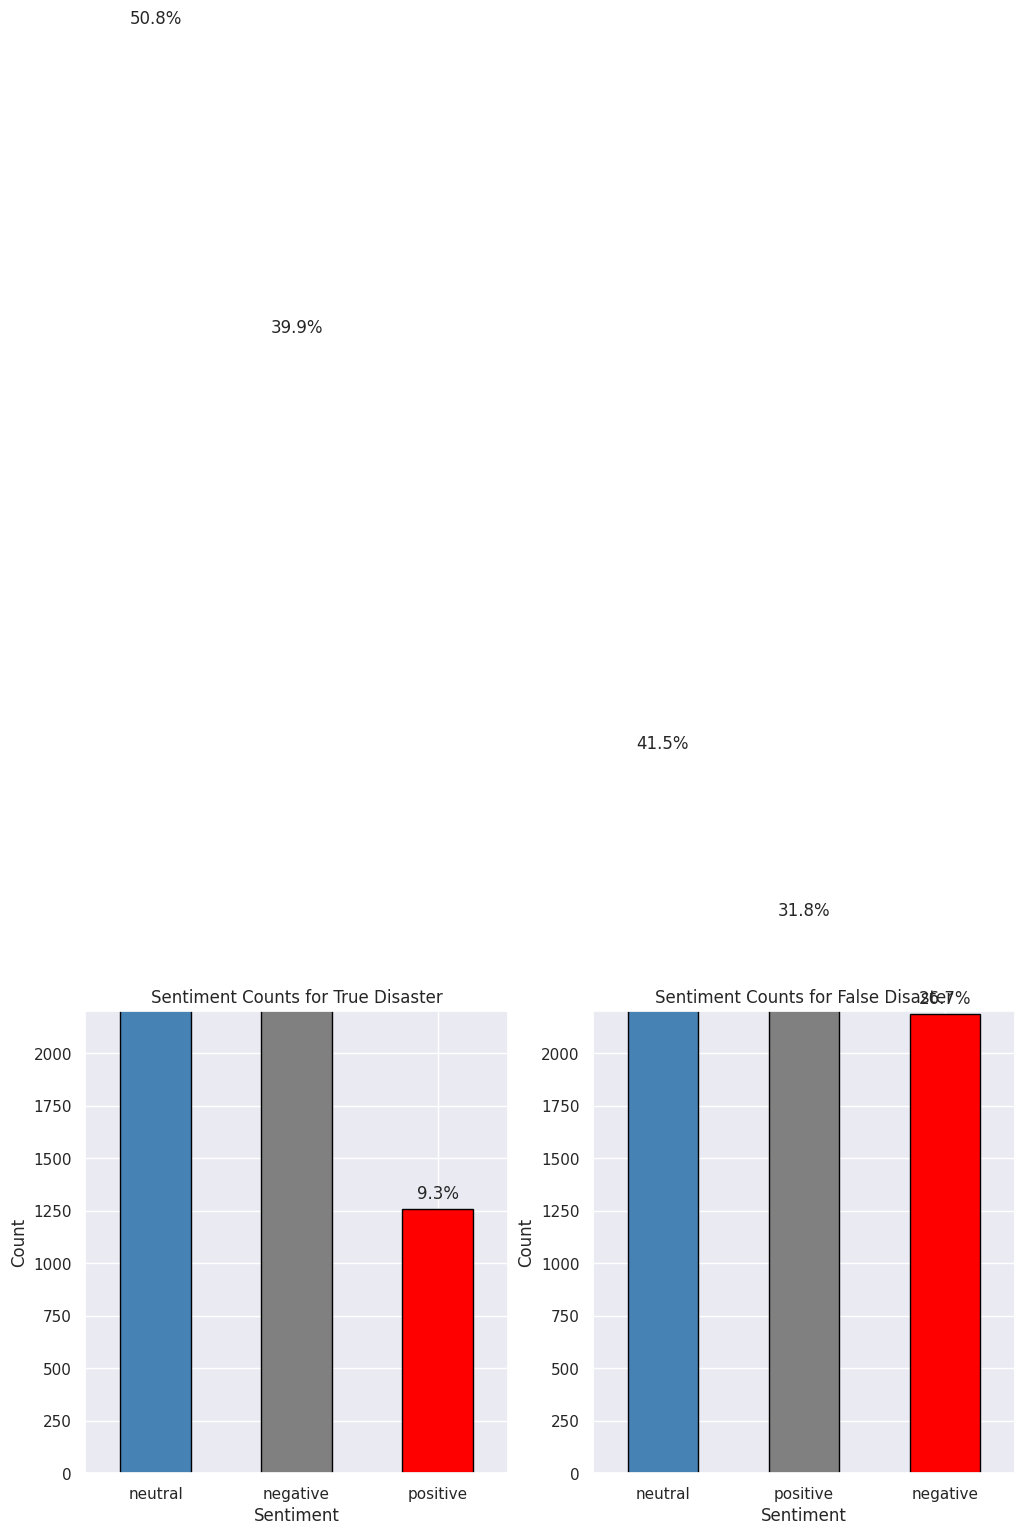

In [16]:
# Filter rows where target == 1 or target == 0
filtered_data_target1 = mwords[mwords['target'] == 1]
filtered_data_target0 = mwords[mwords['target'] == 0]

# Count the occurrences of each sentiment label for both targets
sentiment_counts_target1 = filtered_data_target1['sentiment'].apply(lambda x: x.get('label', '')).value_counts()
sentiment_counts_target0 = filtered_data_target0['sentiment'].apply(lambda x: x.get('label', '')).value_counts()

# Calculate percentages
total_target1 = sentiment_counts_target1.sum()
total_target0 = sentiment_counts_target0.sum()
percent_target1 = sentiment_counts_target1 / total_target1 * 100
percent_target0 = sentiment_counts_target0 / total_target0 * 100

# Create a bar plot for all sentiments
plt.figure(figsize=(12, 6))

# Bar plot for target == 1
plt.subplot(121)
sentiment_counts_target1.plot(kind='bar', color=['steelblue', 'gray', 'red'], edgecolor='black')
plt.title('Sentiment Counts for True Disaster')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.ylim(0, 2200)  # Set y-axis limit
for i, v in enumerate(sentiment_counts_target1):
    plt.text(i, v + 50, f"{percent_target1[i]:.1f}%", ha='center')

# Bar plot for target == 0
plt.subplot(122)
sentiment_counts_target0.plot(kind='bar', color=['steelblue', 'gray', 'red'], edgecolor='black')
plt.title('Sentiment Counts for False Disaster')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.ylim(0, 2200)  # Set y-axis limit
for i, v in enumerate(sentiment_counts_target0):
    plt.text(i, v + 50, f"{percent_target0[i]:.1f}%", ha='center')

plt.tight_layout()
plt.show()


###The above results show that there is a slight different distribution of sentiments between True Vs False labels, with a slight increase in positive feelings associated with a False label.

##Lets look into topic distribution

In [17]:
model = tweetnlp.load_model('topic_classification')

In [18]:
def transform_topic(x):
    # Check if x is a dictionary and 'label' is a key
    if isinstance(x, dict) and 'label' in x:
        # Check the type of the value associated with 'label' and if it's empty
        if isinstance(x['label'], list):  # If the value is a list
            return x['label'][0] if x['label'] else ['unknown']  # Replace empty list with ['unknown']
        elif isinstance(x['label'], set):  # If the value is a set
            return next(iter(x['label']), 'unknown') if x['label'] else {'unknown'}  # Replace empty set with {'unknown'}
        else:
            return 'unknown'  # Fallback for other types or empty 'label'
    else:
        # Handle cases where x is None, an empty string, or any other "empty" value
        if not x:
            return 'unknown'
        # If x is already a string and not considered "empty", just return it
        return x


In [19]:
topics_df = tweets_df.copy(deep=True)
topics_df.reset_index(inplace = True)
start_time = time.time()
topics_df['topic'] = 'unknown'

start_time = time.time()

# Create a tqdm instance to display the progress bar
for i in tqdm(range(topics_df.shape[0])):
    check_txt = topics_df.iloc[i]['text']
    # Uncomment the following lines if needed
    # check_txt = check_txt.lower()
    # check_txt = check_txt.translate(str.maketrans('', '', string.punctuation))
    topic = model.topic(check_txt)
    topic = transform_topic(topic)
    topics_df['topic'][i] = topic
    #topics_df['topic'] = topics_df['topic'].apply(lambda x: x['label'])
    if isinstance(topics_df.at[i, 'topic'], dict) and 'label' in topics_df.at[i, 'topic']:
      # Access 'label' for the i-th row and assume it's a list and get the first element
      topics_df.at[i, 'topic'] = topics_df.at[i, 'topic']['label'][0]

print("\n--- %s seconds ---" % (time.time() - start_time))

Streaming output truncated to the last 5000 lines.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topics_df['topic'][i] = topic
<ipython-input-19-e1011bd2221b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topics_df['topic'][i] = topic
<ipython-input-19-e1011bd2221b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topics_df['topic'][i] = topic
<ipython-input-19-e1011bd2221b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://panda


--- 404.46233439445496 seconds ---


In [20]:
topics_df.head(10)

,index,id,keyword,location,text,target,source,topic
0,0,1,,,Our Deeds are the Reason of this #earthquake M...,1,train,diaries_&_daily_life
1,1,4,,,Forest fire near La Ronge Sask. Canada,1,train,news_&_social_concern
2,2,5,,,All residents asked to 'shelter in place' are ...,1,train,news_&_social_concern
3,3,6,,,"13,000 people receive #wildfires evacuation or...",1,train,news_&_social_concern
4,4,7,,,Just got sent this photo from Ruby #Alaska as ...,1,train,news_&_social_concern
5,5,8,,,#RockyFire Update => California Hwy. 20 closed...,1,train,news_&_social_concern
6,6,10,,,#flood #disaster Heavy rain causes flash flood...,1,train,news_&_social_concern
7,7,13,,,I'm on top of the hill and I can see a fire in...,1,train,[unknown]
8,8,14,,,There's an emergency evacuation happening now ...,1,train,news_&_social_concern
9,9,15,,,I'm afraid that the tornado is coming to our a...,1,train,news_&_social_concern


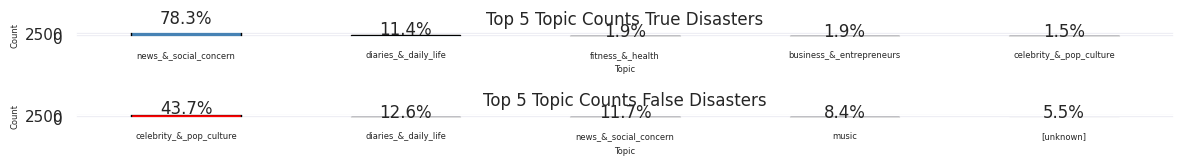

In [21]:
font_size = 6
# Count the occurrences of each topic for target == 1
filtered_data_target1 = topics_df[topics_df['target'] == 1]
topic_counts_target1 = filtered_data_target1['topic'].value_counts()

# Count the occurrences of each topic for target == 0
filtered_data_target0 = topics_df[topics_df['target'] == 0]
topic_counts_target0 = filtered_data_target0['topic'].value_counts()

# Set the desired number of top topics
top_n = 5

# Select the top N topics for target == 1
top_topics_target1 = topic_counts_target1[:top_n]

# Calculate the total count for target == 1
total_target1 = topic_counts_target1.sum()

# Calculate the percentage for each topic for target == 1
percentages_target1 = (top_topics_target1 / total_target1) * 100

# Create a bar plot for the top topics (target == 1)
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)  # Two rows, one column, first subplot
top_topics_target1.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title(f'Top {top_n} Topic Counts True Disasters')
plt.xlabel('Topic', fontsize=font_size)
plt.ylabel('Count', fontsize=font_size)
plt.xticks(rotation=0, ha='center', fontsize=font_size)
plt.ylim(0, 3500)  # Set y-axis limit to 3500

# Annotate bars with percentages (target == 1)
for i, v in enumerate(top_topics_target1):
    plt.text(i, v + 50, f"{percentages_target1[i]:.1f}%", ha='center')

# Select the top N topics for target == 0
top_topics_target0 = topic_counts_target0[:top_n]

# Calculate the total count for target == 0
total_target0 = topic_counts_target0.sum()

# Calculate the percentage for each topic for target == 0
percentages_target0 = (top_topics_target0 / total_target0) * 100

# Create a bar plot for the top topics (target == 0)
plt.subplot(2, 1, 2)  # Two rows, one column, second subplot
top_topics_target0.plot(kind='bar', color='red', edgecolor='black')
plt.title(f'Top {top_n} Topic Counts False Disasters')
plt.xlabel('Topic', fontsize=font_size)
plt.ylabel('Count', fontsize=font_size)
plt.xticks(rotation=0, ha='center', fontsize=font_size)
plt.ylim(0, 3500)  # Set y-axis limit to 3500

# Annotate bars with percentages (target == 0)
for i, v in enumerate(top_topics_target0):
    plt.text(i, v + 50, f"{percentages_target0[i]:.1f}%", ha='center')

plt.tight_layout()
plt.show()




###The above shows a strong tendency that text associated with a True Disaster are tagged as 'news & social concern' more often the False Disasters.

##Irony analysis:
### The following analyzes the text and qualifies the body of text as having irony or not.

In [22]:
model_irony = tweetnlp.load_model('irony')

In [23]:
irony_df = tweets_df.copy(deep=True)
irony_df.reset_index(inplace = True)
start_time = time.time()
irony_df['irony'] = 'unknown'

# Assuming you have already imported necessary libraries and defined 'model_irony'

start_time = time.time()

# Create a tqdm instance to display the progress bar
for i in tqdm(range(irony_df.shape[0])):
    check_txt = irony_df.iloc[i]['text']
    # Uncomment the following lines if needed
    # check_txt = check_txt.lower()
    # check_txt = check_txt.translate(str.maketrans('', '', string.punctuation))
    irony = model_irony.irony(check_txt)
    irony_df['irony'][i] = irony
    #irony_df['irony'] = irony_df['irony'].apply(lambda x: x['label'])

print("\n--- %s seconds ---" % (time.time() - start_time))

Streaming output truncated to the last 5000 lines.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  irony_df['irony'][i] = irony
<ipython-input-23-f623f22f3558>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  irony_df['irony'][i] = irony
 95%|█████████▌| 20685/21683 [06:30<00:16, 60.98it/s]<ipython-input-23-f623f22f3558>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  irony_df['irony'][i] = irony
<ipython-input-23-f623f22f3558>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

S


--- 408.7300157546997 seconds ---


<ipython-input-24-4ef7cc46a080>:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


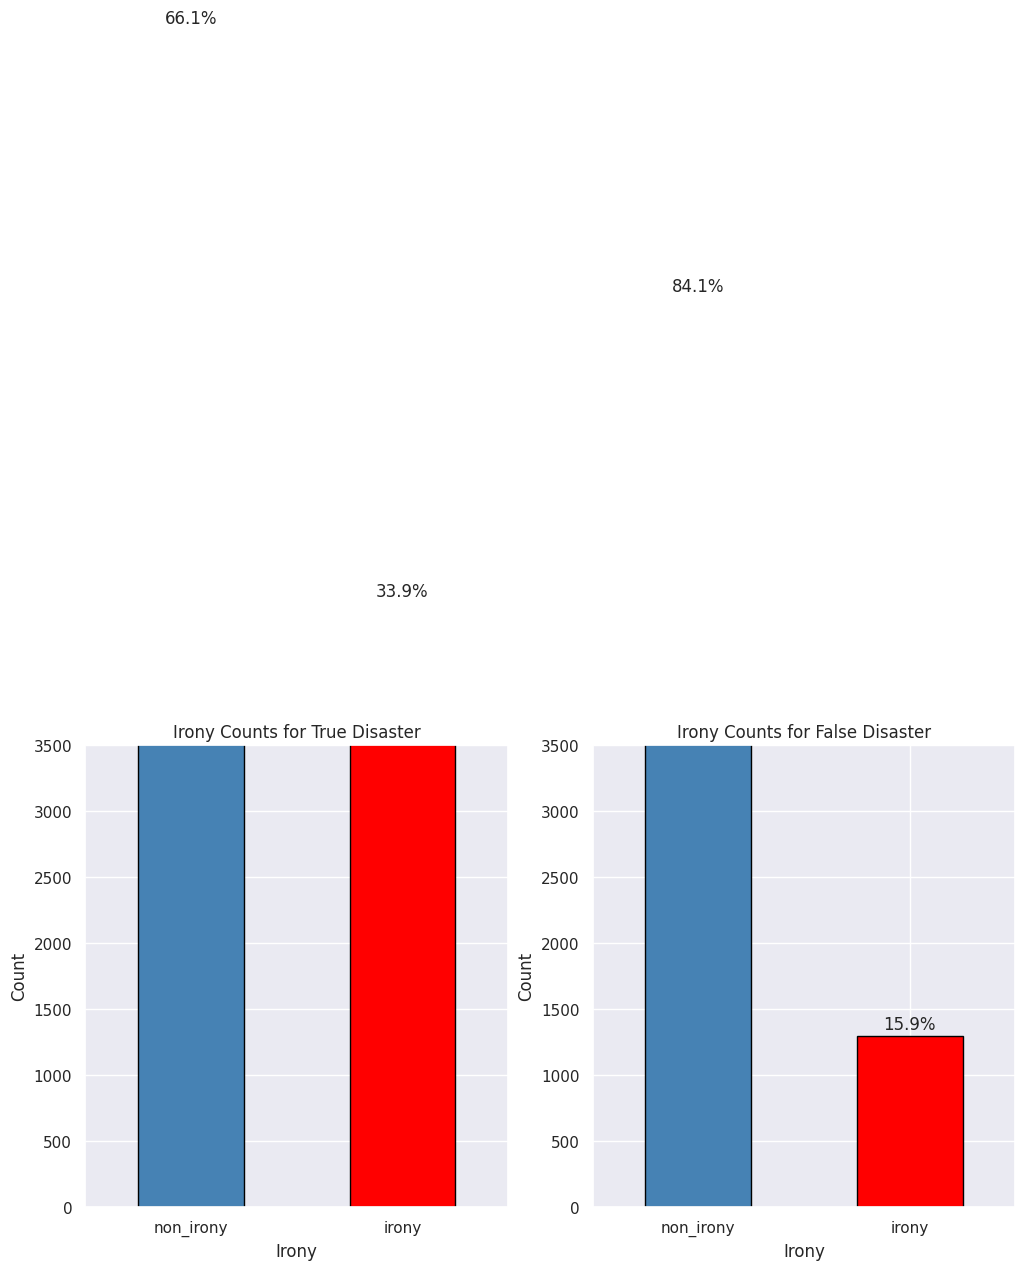

In [24]:
# Filter rows where target == 1 or target == 0
filtered_data_target1 = irony_df[irony_df['target'] == 1]
filtered_data_target0 = irony_df[irony_df['target'] == 0]

# Count the occurrences of each sentiment label for both targets
sentiment_counts_target1 = filtered_data_target1['irony'].apply(lambda x: x.get('label', '')).value_counts()
sentiment_counts_target0 = filtered_data_target0['irony'].apply(lambda x: x.get('label', '')).value_counts()

# Calculate percentages
total_target1 = sentiment_counts_target1.sum()
total_target0 = sentiment_counts_target0.sum()
percent_target1 = sentiment_counts_target1 / total_target1 * 100
percent_target0 = sentiment_counts_target0 / total_target0 * 100

# Create a bar plot for all sentiments
plt.figure(figsize=(12, 6))

# Bar plot for target == 1
plt.subplot(121)
sentiment_counts_target1.plot(kind='bar', color=['steelblue','red'], edgecolor='black')
plt.title('Irony Counts for True Disaster')
plt.xlabel('Irony')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.ylim(0, 3500)  # Set y-axis limit
for i, v in enumerate(sentiment_counts_target1):
    plt.text(i, v + 50, f"{percent_target1[i]:.1f}%", ha='center')

# Bar plot for target == 0
plt.subplot(122)
sentiment_counts_target0.plot(kind='bar', color=['steelblue','red'], edgecolor='black')
plt.title('Irony Counts for False Disaster')
plt.xlabel('Irony')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.ylim(0, 3500)  # Set y-axis limit
for i, v in enumerate(sentiment_counts_target0):
    plt.text(i, v + 50, f"{percent_target0[i]:.1f}%", ha='center')

plt.tight_layout()
plt.show()


For True Disasters the algorithm tags a larger percentage of text as being made with irony. Maybe the algorithm is giving a false positive. We expected the opposite results.

##The following analyzes the emotion of the body of text.

In [25]:
model_emotion = tweetnlp.load_model('emotion')

In [26]:
emotion_df = tweets_df.copy(deep=True)
emotion_df.reset_index(inplace = True)
start_time = time.time()
emotion_df['emotion'] = 'unknown'

# Assuming you have already imported necessary libraries and defined 'model_emotion'

start_time = time.time()

# Create a tqdm instance to display the progress bar
for i in tqdm(range(emotion_df.shape[0])):
    check_txt = emotion_df.iloc[i]['text']
    # Uncomment the following lines if needed
    # check_txt = check_txt.lower()
    # check_txt = check_txt.translate(str.maketrans('', '', string.punctuation))
    emotion = model_emotion.emotion(check_txt)
    emotion_df['emotion'][i] = emotion
    #emotion_df['emotion'] = emotion_df['emotion'].apply(lambda x: x['label'])

print("\n--- %s seconds ---" % (time.time() - start_time))

Streaming output truncated to the last 5000 lines.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emotion_df['emotion'][i] = emotion
 95%|█████████▌| 20684/21683 [06:25<00:21, 46.78it/s]<ipython-input-26-f4e476c34871>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emotion_df['emotion'][i] = emotion
<ipython-input-26-f4e476c34871>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emotion_df['emotion'][i] = emotion
<ipython-input-26-f4e476c34871>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f


--- 404.50973868370056 seconds ---


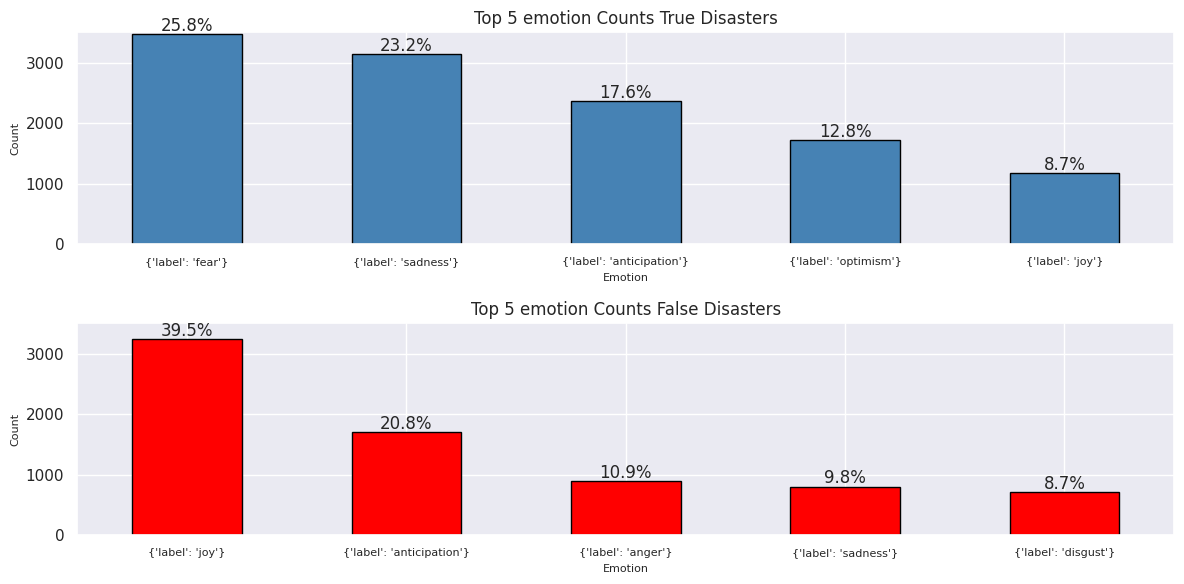

In [27]:
font_size = 8
# Count the occurrences of each emotion for target == 1
filtered_data_target1 = emotion_df[emotion_df['target'] == 1]
emotion_counts_target1 = filtered_data_target1['emotion'].value_counts()

# Count the occurrences of each emotion for target == 0
filtered_data_target0 = emotion_df[emotion_df['target'] == 0]
emotion_counts_target0 = filtered_data_target0['emotion'].value_counts()

# Set the desired number of top emotions
top_n = 5

# Select the top N emotions for target == 1
top_emotions_target1 = emotion_counts_target1[:top_n]

# Calculate the total count for target == 1
total_target1 = emotion_counts_target1.sum()

# Calculate the percentage for each emotion for target == 1
percentages_target1 = (top_emotions_target1 / total_target1) * 100

# Create a bar plot for the top emotions (target == 1)
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)  # Two rows, one column, first subplot
top_emotions_target1.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title(f'Top {top_n} emotion Counts True Disasters')
plt.xlabel('Emotion', fontsize=font_size)
plt.ylabel('Count', fontsize=font_size)
plt.xticks(rotation=0, ha='center', fontsize=font_size)
plt.ylim(0, 3500)  # Set y-axis limit to 3500

# Annotate bars with percentages (target == 1)
for i, v in enumerate(top_emotions_target1):
    plt.text(i, v + 50, f"{percentages_target1[i]:.1f}%", ha='center')

# Select the top N emotions for target == 0
top_emotions_target0 = emotion_counts_target0[:top_n]

# Calculate the total count for target == 0
total_target0 = emotion_counts_target0.sum()

# Calculate the percentage for each emotion for target == 0
percentages_target0 = (top_emotions_target0 / total_target0) * 100

# Create a bar plot for the top emotions (target == 0)
plt.subplot(2, 1, 2)  # Two rows, one column, second subplot
top_emotions_target0.plot(kind='bar', color='red', edgecolor='black')
plt.title(f'Top {top_n} emotion Counts False Disasters')
plt.xlabel('Emotion', fontsize=font_size)
plt.ylabel('Count', fontsize=font_size)
plt.xticks(rotation=0, ha='center', fontsize=font_size)
plt.ylim(0, 3500)  # Set y-axis limit to 3500

# Annotate bars with percentages (target == 0)
for i, v in enumerate(top_emotions_target0):
    plt.text(i, v + 50, f"{percentages_target0[i]:.1f}%", ha='center')

plt.tight_layout()
plt.show()




In [28]:
emotion_df.head(3)

,index,id,keyword,location,text,target,source,emotion
0,0,1,,,Our Deeds are the Reason of this #earthquake M...,1,train,{'label': 'optimism'}
1,1,4,,,Forest fire near La Ronge Sask. Canada,1,train,{'label': 'fear'}
2,2,5,,,All residents asked to 'shelter in place' are ...,1,train,{'label': 'disgust'}


In [29]:
import pandas as pd

emotion_df2 = pd.DataFrame(emotion_df)

# Append the 'label' value from the 'emotion' column to the 'text' column
emotion_df2['text'] = emotion_df2.apply(lambda row: row['text'] + " (" + row['emotion']['label'] + ")", axis=1)

emotion_df2.head(3)


,index,id,keyword,location,text,target,source,emotion
0,0,1,,,Our Deeds are the Reason of this #earthquake M...,1,train,{'label': 'optimism'}
1,1,4,,,Forest fire near La Ronge Sask. Canada (fear),1,train,{'label': 'fear'}
2,2,5,,,All residents asked to 'shelter in place' are ...,1,train,{'label': 'disgust'}


In [30]:
import pandas as pd

emotion_df2 = pd.DataFrame(emotion_df)

# Append the 'label' value from the 'emotion' column to the 'text' column
emotion_df2['text'] = emotion_df2.apply(lambda row: row['text'] + " (" + row['emotion']['label'] + ")", axis=1)

emotion_df2.head(3)

,index,id,keyword,location,text,target,source,emotion
0,0,1,,,Our Deeds are the Reason of this #earthquake M...,1,train,{'label': 'optimism'}
1,1,4,,,Forest fire near La Ronge Sask. Canada (fear),1,train,{'label': 'fear'}
2,2,5,,,All residents asked to 'shelter in place' are ...,1,train,{'label': 'disgust'}


In [31]:
# Merging dataframes to add the 'topic' column
merged_df = pd.merge(mwords, topics_df[['text', 'topic']], on='text', how='left')

# Merging dataframes to add the 'irony' column
merged2_df = pd.merge(merged_df, irony_df[['text', 'irony']], on='text', how='left')

# Merging dataframes to add the 'emotion' column
merged3_df = pd.merge(merged2_df, emotion_df[['text', 'emotion']], on='text', how='left')

merged3_df.head(3)

,index,id,keyword,location,text,target,source,sentiment,topic,irony,emotion
0,0,1,,,Our Deeds are the Reason of this #earthquake M...,1,train,{'label': 'negative'},diaries_&_daily_life,{'label': 'non_irony'},{'label': 'optimism'}
1,1,4,,,Forest fire near La Ronge Sask. Canada,1,train,{'label': 'neutral'},news_&_social_concern,{'label': 'non_irony'},{'label': 'fear'}
2,2,5,,,All residents asked to 'shelter in place' are ...,1,train,{'label': 'neutral'},news_&_social_concern,{'label': 'non_irony'},{'label': 'disgust'}


In [32]:
def transform_column(x):
    # Check if x is a dictionary and 'label' is a key
    if isinstance(x, dict) and 'label' in x:
        # Check the type of the value associated with 'label' and if it's empty
        if isinstance(x['label'], list):  # If the value is a list
            return x['label'][0] if x['label'] else ['unknown']  # Replace empty list with ['unknown']
        elif isinstance(x['label'], set):  # If the value is a set
            return next(iter(x['label']), 'unknown') if x['label'] else {'unknown'}  # Replace empty set with {'unknown'}
        else:
            return x  # Fallback for other types or empty 'label'
    else:
        # Handle cases where x is None, an empty string, or any other "empty" value
        if not x:
            return x
        # If x is already a string and not considered "empty", just return it
        return topic

In [33]:
import pandas as pd

merged4_df = pd.DataFrame(merged3_df)

# Append the 'label' value from the 'sentiment' column to the 'text' column
merged4_df['text'] = merged4_df.apply(lambda row: row['text'] + " " + row['sentiment']['label'] + "", axis=1)

# Append the 'label' value from the 'topic' column to the 'text' column
merged4_df['text'] = merged4_df.apply(lambda row: f"{row['text']}  ({transform_column(row['topic'])})", axis=1)

# Append the 'label' value from the 'irony' column to the 'text' column
merged4_df['text'] = merged4_df.apply(lambda row: row['text'] + " " + row['irony']['label'] + "", axis=1)

# Append the 'label' value from the 'emotion' column to the 'text' column
merged4_df['text'] = merged4_df.apply(lambda row: row['text'] + " " + row['emotion']['label'] + "", axis=1)

merged4_df.head(3)

,index,id,keyword,location,text,target,source,sentiment,topic,irony,emotion
0,0,1,,,Our Deeds are the Reason of this #earthquake M...,1,train,{'label': 'negative'},diaries_&_daily_life,{'label': 'non_irony'},{'label': 'optimism'}
1,1,4,,,Forest fire near La Ronge Sask. Canada neutral...,1,train,{'label': 'neutral'},news_&_social_concern,{'label': 'non_irony'},{'label': 'fear'}
2,2,5,,,All residents asked to 'shelter in place' are ...,1,train,{'label': 'neutral'},news_&_social_concern,{'label': 'non_irony'},{'label': 'disgust'}


In [34]:
merged4_df['cleaned_text'] = merged4_df['text'].str.replace(r"[()#]", "", regex=True)
merged4_df.head(3)

,index,id,keyword,location,text,target,source,sentiment,topic,irony,emotion,cleaned_text
0,0,1,,,Our Deeds are the Reason of this #earthquake M...,1,train,{'label': 'negative'},diaries_&_daily_life,{'label': 'non_irony'},{'label': 'optimism'},Our Deeds are the Reason of this earthquake Ma...
1,1,4,,,Forest fire near La Ronge Sask. Canada neutral...,1,train,{'label': 'neutral'},news_&_social_concern,{'label': 'non_irony'},{'label': 'fear'},Forest fire near La Ronge Sask. Canada neutral...
2,2,5,,,All residents asked to 'shelter in place' are ...,1,train,{'label': 'neutral'},news_&_social_concern,{'label': 'non_irony'},{'label': 'disgust'},All residents asked to 'shelter in place' are ...


In [37]:
# from google.colab import drive
# drive.mount('/content/drive')

file_path = '/content/drive/My Drive/DS266 Project/Final Work/train_enhanced_plus.csv'

merged4_df.to_csv(file_path, index=False)

#End of Sentiment Analysis document